## Import packages

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image

## Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each


In [33]:
metadata = pd.read_csv('./monkey/monkey_labels.txt',
                       names = ['Label','Latin_Name','Common_Name','Train_Images','Validation_Images'],
                       skiprows=1)
metadata = metadata[metadata['Label'].isin(['n0   ', 'n1   ', 'n2   '])]
metadata


,Label,Latin_Name,Common_Name,Train_Images,Validation_Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27


In [55]:
# Define data transformations for data augmentation and normalization
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_transforms = {
    'training/training': data_transform,
    'validation/validation': data_transform,
}



In [56]:
# Define the data directory
data_dir = 'monkey'
train_dir = data_dir +'/training/training/'
test_dir = data_dir +'/validation/validation'


In [57]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['training/training', 'validation/validation']}
image_datasets

{'training/training': Dataset ImageFolder
     Number of datapoints: 326
     Root location: monkey/training/training
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation/validation': Dataset ImageFolder
     Number of datapoints: 81
     Root location: monkey/validation/validation
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [58]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['training/training', 'validation/validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training/training', 'validation/validation']}
print(dataset_sizes)

class_names = image_datasets['training/training'].classes
class_names

{'training/training': 326, 'validation/validation': 81}


['n0', 'n1', 'n2']

## Step 2. Split this data between 80% training and 20% test


In [226]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split,TensorDataset

dataset = ImageFolder(train_dir, transform = data_transform)
train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = image_datasets['validation/validation']

In [61]:
len(train_dataset),len(val_dataset),len(test_dataset)

(260, 66, 81)

## Step 3. Preprocess the data as you see fit

augmentation steps took place as an initial step earlier during data loading



In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


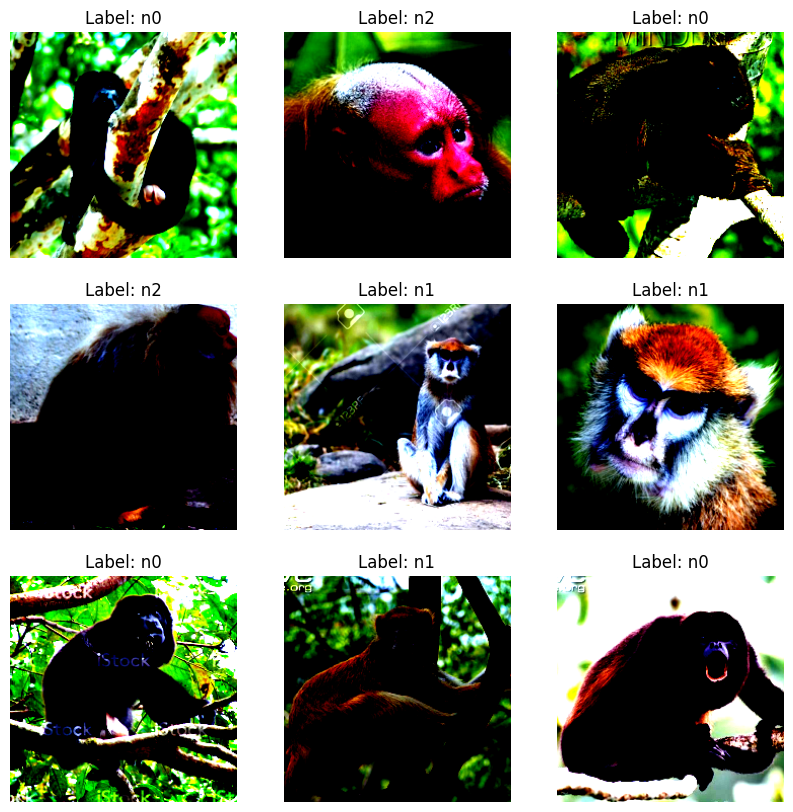

In [63]:
# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()

## Step 4. Create a Convolutional Neural Network model to learn about your training set 


In [177]:


import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Calculate the input size to the first fully connected layer
        self.fc_input_size = self._get_fc_input_size()
        print(self.fc_input_size )
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

    def _get_fc_input_size(self):
        # Dummy input to calculate the output size after convolutional and pooling layers
        x = torch.randn(1, 3, 224, 224)
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        return x.size(1)

# Instantiate the model
num_classes = 3
cnn_model = CustomModel(num_classes)
cnn_model


43264


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=43264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

Compile the model: choose the optimizers. Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.


In [178]:


# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_model(cnn_model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 1.2251, Accuracy: 0.3577
Epoch 2/5, Loss: 0.5936, Accuracy: 0.7923
Epoch 3/5, Loss: 0.3977, Accuracy: 0.8423
Epoch 4/5, Loss: 0.3672, Accuracy: 0.8538
Epoch 5/5, Loss: 0.2349, Accuracy: 0.9115


Training loop with Data Augmentation layers to avoid overfitting

In [179]:

# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss() #equivalent to sparse categorical entropy loss from Keras https://stackoverflow.com/questions/63403485/is-there-a-version-of-sparse-categorical-cross-entropy-in-pytorch

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            #data_augmented_inputs = torch.stack([transforms.RandomVerticalFlip(p=0.5)(img) for img in data_augmented_inputs])# <- experimental
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            data_augmented_inputs = torch.stack([transforms.RandomPerspective(distortion_scale=0.5, p=0.5)(img) for img in data_augmented_inputs]) # <- experimental
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(data_augmented_inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_model(cnn_model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 0.4783, Accuracy: 0.8115
Epoch 2/5, Loss: 0.3919, Accuracy: 0.8462
Epoch 3/5, Loss: 0.3000, Accuracy: 0.9038
Epoch 4/5, Loss: 0.2685, Accuracy: 0.9231
Epoch 5/5, Loss: 0.2644, Accuracy: 0.9115


## Step 5. Make predictions on the test data and compare them to the expected categories

In [180]:
test_dir = data_dir +'/validation/validation'
n0_set = test_dir + '/n0/'
n1_set = test_dir + '/n1/'
n2_set = test_dir + '/n2/'

set_dir = {'n0':n0_set,'n1':n1_set,'n2':n2_set}

In [181]:
#image_path = '/content/test_img.jpeg'  # Replace with the path to your image

def make_inference(model,set):
    print(f"Predicting which class ({set}) each image belongs to with confidence measure. \n")
    results = {}
    for image_path in os.listdir(set_dir[set]):
        image = Image.open(set_dir[set] + image_path)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
        
        # Perform inference
        with torch.no_grad():
            output = model(input_batch)

        # Get the predicted class
        _, predicted_class = output.max(1)

        # Map the predicted class to the class name
        #class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
        predicted_class_name = class_names[predicted_class.item()]
        probabilities = torch.softmax(output, dim=1)
        confidence = torch.max(probabilities).item()
        results[image_path] = predicted_class_name
        print(f"{image_path}: {predicted_class_name} - {confidence*100:.2f}% confidence.")
    
    non_matches = [k for k,v in results.items() if v != set]
    #print(non_matches)
    accuracy = len(non_matches)/len(results)
    print(f"\n Overall accuracy: {1-accuracy}")
    
    #Image.open(str(set_dir[set] + non_matches[0]))


In [182]:
n0_results = make_inference(cnn_model,'n0')

Predicting which class (n0) each image belongs to with confidence measure. 

n0010.jpg: n0 - 92.17% confidence.
n0011.jpg: n0 - 95.80% confidence.
n0013.jpg: n2 - 56.46% confidence.
n0012.jpg: n0 - 91.30% confidence.
n0016.jpg: n0 - 80.04% confidence.
n0017.jpg: n0 - 54.61% confidence.
n0015.jpg: n0 - 98.19% confidence.
n0014.jpg: n0 - 88.19% confidence.
n010.jpg: n0 - 99.11% confidence.
n004.jpg: n0 - 88.51% confidence.
n005.jpg: n2 - 44.63% confidence.
n011.jpg: n1 - 99.48% confidence.
n007.jpg: n0 - 97.88% confidence.
n013.jpg: n2 - 49.26% confidence.
n012.jpg: n0 - 60.64% confidence.
n006.jpg: n0 - 77.96% confidence.
n002.jpg: n0 - 98.97% confidence.
n016.jpg: n0 - 74.63% confidence.
n017.jpg: n0 - 84.35% confidence.
n003.jpg: n1 - 84.58% confidence.
n015.jpg: n2 - 69.75% confidence.
n001.jpg: n0 - 96.47% confidence.
n000.jpg: n0 - 84.35% confidence.
n014.jpg: n1 - 44.23% confidence.
n008.jpg: n0 - 80.63% confidence.
n009.jpg: n1 - 88.73% confidence.

 Overall accuracy: 0.692307692

In [183]:
make_inference(cnn_model,'n1')

Predicting which class (n1) each image belongs to with confidence measure. 

n107.jpg: n0 - 85.12% confidence.
n113.jpg: n1 - 83.89% confidence.
n112.jpg: n1 - 99.46% confidence.
n106.jpg: n1 - 99.36% confidence.
n110.jpg: n1 - 68.73% confidence.
n104.jpg: n1 - 99.46% confidence.
n105.jpg: n2 - 70.72% confidence.
n111.jpg: n2 - 95.60% confidence.
n115.jpg: n1 - 84.34% confidence.
n101.jpg: n1 - 99.90% confidence.
n100.jpg: n2 - 88.07% confidence.
n114.jpg: n1 - 99.90% confidence.
n102.jpg: n2 - 90.08% confidence.
n116.jpg: n1 - 93.12% confidence.
n117.jpg: n1 - 99.40% confidence.
n103.jpg: n1 - 98.60% confidence.
n1012.jpg: n1 - 56.29% confidence.
n1013.jpg: n0 - 63.64% confidence.
n1011.jpg: n1 - 98.02% confidence.
n1010.jpg: n1 - 97.52% confidence.
n1014.jpg: n1 - 96.47% confidence.
n1015.jpg: n1 - 98.33% confidence.
n1016.jpg: n1 - 98.69% confidence.
n119.jpg: n1 - 78.80% confidence.
n118.jpg: n2 - 54.27% confidence.
n120.jpg: n1 - 99.36% confidence.
n108.jpg: n1 - 60.46% confidence

In [184]:
make_inference(cnn_model,'n2')

Predicting which class (n2) each image belongs to with confidence measure. 

n2015.jpg: n1 - 69.24% confidence.
n2014.jpg: n0 - 71.31% confidence.
n2016.jpg: n2 - 92.21% confidence.
n2013.jpg: n1 - 50.07% confidence.
n2012.jpg: n1 - 77.08% confidence.
n2010.jpg: n1 - 74.39% confidence.
n2011.jpg: n2 - 98.97% confidence.
n212.jpg: n2 - 92.42% confidence.
n206.jpg: n2 - 58.25% confidence.
n207.jpg: n2 - 80.54% confidence.
n213.jpg: n2 - 89.20% confidence.
n205.jpg: n2 - 94.76% confidence.
n211.jpg: n1 - 74.48% confidence.
n210.jpg: n2 - 54.64% confidence.
n204.jpg: n2 - 96.31% confidence.
n200.jpg: n2 - 98.03% confidence.
n214.jpg: n2 - 71.34% confidence.
n215.jpg: n1 - 56.90% confidence.
n201.jpg: n2 - 88.63% confidence.
n217.jpg: n1 - 74.75% confidence.
n203.jpg: n1 - 51.92% confidence.
n202.jpg: n2 - 93.36% confidence.
n216.jpg: n2 - 98.72% confidence.
n218.jpg: n2 - 96.09% confidence.
n219.jpg: n2 - 91.36% confidence.
n209.jpg: n2 - 99.54% confidence.
n208.jpg: n2 - 98.22% confidence

## Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [208]:
googlenet_model = models.googlenet(pretrained=True)
googlenet_model.fc=nn.Sequential(
    # nn.Linear(in_features=1024,out_features=512),
    # nn.ReLU(),
    nn.Linear(in_features=1024,out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128,out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=3,bias=True)
) 
googlenet_model.eval()

/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christopherton/Desktop/SJSU_MSDA/255/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Step 7: Train the GoogleNet model and compare the accuracy with the first model.



In [209]:
# Define the optimizer
optimizer = optim.Adam(googlenet_model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_googlenet(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            #data_augmented_inputs = torch.stack([transforms.RandomVerticalFlip(p=0.5)(img) for img in data_augmented_inputs])# <- experimental
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            data_augmented_inputs = torch.stack([transforms.RandomPerspective(distortion_scale=0.5, p=0.5)(img) for img in data_augmented_inputs]) # <- experimental
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(data_augmented_inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 5  # Choose the number of epochs
train_googlenet(googlenet_model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 0.6890, Accuracy: 0.8154
Epoch 2/5, Loss: 0.1086, Accuracy: 0.9731
Epoch 3/5, Loss: 0.1061, Accuracy: 0.9692
Epoch 4/5, Loss: 0.0946, Accuracy: 0.9731
Epoch 5/5, Loss: 0.0698, Accuracy: 0.9846


Training performance with respect to the loss and accuracy metrics are better than the baseline custom CNN model, achieving peak performance by the 2nd epoch and outperforming any iterations of the CNN model up to the 5th epoch.

In [213]:
make_inference(googlenet_model,'n0')

Predicting which class (n0) each image belongs to with confidence measure. 

n0010.jpg: n1 - 83.01% confidence.
n0011.jpg: n1 - 83.52% confidence.
n0013.jpg: n1 - 85.53% confidence.
n0012.jpg: n1 - 88.77% confidence.
n0016.jpg: n1 - 85.69% confidence.
n0017.jpg: n1 - 84.42% confidence.
n0015.jpg: n1 - 82.05% confidence.
n0014.jpg: n1 - 89.11% confidence.
n010.jpg: n1 - 83.32% confidence.
n004.jpg: n1 - 85.28% confidence.
n005.jpg: n1 - 84.77% confidence.
n011.jpg: n1 - 76.63% confidence.
n007.jpg: n1 - 81.34% confidence.
n013.jpg: n1 - 82.73% confidence.
n012.jpg: n1 - 85.69% confidence.
n006.jpg: n1 - 82.57% confidence.
n002.jpg: n1 - 81.23% confidence.
n016.jpg: n1 - 81.29% confidence.
n017.jpg: n1 - 85.59% confidence.
n003.jpg: n1 - 81.24% confidence.
n015.jpg: n1 - 80.07% confidence.
n001.jpg: n1 - 78.28% confidence.
n000.jpg: n1 - 80.63% confidence.
n014.jpg: n1 - 87.56% confidence.
n008.jpg: n1 - 82.25% confidence.
n009.jpg: n1 - 84.40% confidence.

 Overall accuracy: 0.0


In [214]:
make_inference(googlenet_model,'n1')


Predicting which class (n1) each image belongs to with confidence measure. 

n107.jpg: n1 - 78.77% confidence.
n113.jpg: n1 - 84.08% confidence.
n112.jpg: n1 - 83.06% confidence.
n106.jpg: n1 - 70.87% confidence.
n110.jpg: n1 - 87.56% confidence.
n104.jpg: n1 - 83.47% confidence.
n105.jpg: n1 - 88.23% confidence.
n111.jpg: n1 - 71.87% confidence.
n115.jpg: n1 - 85.28% confidence.
n101.jpg: n1 - 90.61% confidence.
n100.jpg: n1 - 83.67% confidence.
n114.jpg: n1 - 81.44% confidence.
n102.jpg: n1 - 79.53% confidence.
n116.jpg: n1 - 88.21% confidence.
n117.jpg: n1 - 76.28% confidence.
n103.jpg: n1 - 83.40% confidence.
n1012.jpg: n1 - 86.60% confidence.
n1013.jpg: n1 - 86.02% confidence.
n1011.jpg: n1 - 79.05% confidence.
n1010.jpg: n1 - 82.10% confidence.
n1014.jpg: n1 - 84.41% confidence.
n1015.jpg: n1 - 84.89% confidence.
n1016.jpg: n1 - 85.10% confidence.
n119.jpg: n1 - 85.14% confidence.
n118.jpg: n1 - 88.22% confidence.
n120.jpg: n1 - 82.26% confidence.
n108.jpg: n1 - 85.73% confidence

In [217]:
make_inference(googlenet_model,'n2')

Predicting which class (n2) each image belongs to with confidence measure. 

n2015.jpg: n1 - 88.33% confidence.
n2014.jpg: n1 - 75.57% confidence.
n2016.jpg: n1 - 76.50% confidence.
n2013.jpg: n1 - 84.05% confidence.
n2012.jpg: n1 - 89.35% confidence.
n2010.jpg: n1 - 87.28% confidence.
n2011.jpg: n1 - 83.38% confidence.
n212.jpg: n1 - 83.41% confidence.
n206.jpg: n1 - 83.35% confidence.
n207.jpg: n1 - 74.45% confidence.
n213.jpg: n1 - 88.08% confidence.
n205.jpg: n1 - 82.17% confidence.
n211.jpg: n1 - 86.17% confidence.
n210.jpg: n1 - 74.35% confidence.
n204.jpg: n1 - 89.96% confidence.
n200.jpg: n1 - 78.83% confidence.
n214.jpg: n1 - 77.30% confidence.
n215.jpg: n1 - 83.96% confidence.
n201.jpg: n1 - 85.77% confidence.
n217.jpg: n1 - 79.87% confidence.
n203.jpg: n1 - 77.18% confidence.
n202.jpg: n1 - 77.95% confidence.
n216.jpg: n1 - 84.75% confidence.
n218.jpg: n1 - 77.10% confidence.
n219.jpg: n1 - 82.08% confidence.
n209.jpg: n1 - 75.10% confidence.
n208.jpg: n1 - 82.52% confidence

The GoogleNet model perfectly classifies images from the 2nd class with 100% accuracy and fails to classify any images from class 1 or class 3. This could be a sign of overfiting and training bias, rooted in the object `train_dataloader` unevenly generated from the 80/20 split - due to data imbalance between training and testing sets. By taking a random 0.8 proportion of the length of the training subfolder, there is no guarantee of a representative proportion of training samples per class.

### Stratified Train/Test split

In [282]:
from collections import Counter
Counter(dataset.targets)

Counter({1: 111, 2: 110, 0: 105})

3 custom categories of at least 100 images each



In [259]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
BATCH_SIZE = 32

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(dataset)),
    dataset.targets,
    stratify=dataset.targets,
    test_size=TEST_SIZE
)

# generate subset based on indices
train_split = Subset(dataset, train_indices)
test_split = Subset(dataset, test_indices)

# create batches
train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE)

In [260]:
train_googlenet(googlenet_model, train_batches, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 0.0107, Accuracy: 1.0000
Epoch 2/5, Loss: 0.0044, Accuracy: 1.0000
Epoch 3/5, Loss: 0.0035, Accuracy: 1.0000
Epoch 4/5, Loss: 0.0079, Accuracy: 0.9962
Epoch 5/5, Loss: 0.0397, Accuracy: 0.9885


In [267]:
make_inference(googlenet_model,'n0')

Predicting which class (n0) each image belongs to with confidence measure. 

n0010.jpg: n0 - 53.69% confidence.
n0011.jpg: n0 - 60.74% confidence.
n0013.jpg: n0 - 74.65% confidence.
n0012.jpg: n0 - 59.80% confidence.
n0016.jpg: n0 - 59.46% confidence.
n0017.jpg: n0 - 74.64% confidence.
n0015.jpg: n0 - 64.56% confidence.
n0014.jpg: n0 - 61.70% confidence.
n010.jpg: n0 - 65.20% confidence.
n004.jpg: n0 - 61.54% confidence.
n005.jpg: n0 - 76.52% confidence.
n011.jpg: n0 - 71.71% confidence.
n007.jpg: n0 - 74.29% confidence.
n013.jpg: n0 - 53.81% confidence.
n012.jpg: n0 - 64.39% confidence.
n006.jpg: n0 - 66.76% confidence.
n002.jpg: n0 - 58.28% confidence.
n016.jpg: n0 - 67.08% confidence.
n017.jpg: n0 - 66.74% confidence.
n003.jpg: n0 - 66.51% confidence.
n015.jpg: n0 - 62.03% confidence.
n001.jpg: n0 - 67.77% confidence.
n000.jpg: n0 - 69.60% confidence.
n014.jpg: n0 - 63.93% confidence.
n008.jpg: n0 - 68.55% confidence.
n009.jpg: n0 - 68.58% confidence.

 Overall accuracy: 1.0


In [270]:
make_inference(googlenet_model,'n1')

Predicting which class (n1) each image belongs to with confidence measure. 

n107.jpg: n0 - 73.18% confidence.
n113.jpg: n0 - 60.13% confidence.
n112.jpg: n0 - 62.64% confidence.
n106.jpg: n0 - 51.57% confidence.
n110.jpg: n1 - 51.99% confidence.
n104.jpg: n0 - 62.85% confidence.
n105.jpg: n0 - 66.57% confidence.
n111.jpg: n0 - 71.81% confidence.
n115.jpg: n0 - 66.43% confidence.
n101.jpg: n0 - 64.69% confidence.
n100.jpg: n0 - 57.62% confidence.
n114.jpg: n0 - 67.21% confidence.
n102.jpg: n0 - 53.72% confidence.
n116.jpg: n0 - 68.52% confidence.
n117.jpg: n0 - 76.57% confidence.
n103.jpg: n0 - 73.53% confidence.
n1012.jpg: n0 - 52.90% confidence.
n1013.jpg: n0 - 63.67% confidence.
n1011.jpg: n0 - 53.43% confidence.
n1010.jpg: n0 - 65.86% confidence.
n1014.jpg: n0 - 69.02% confidence.
n1015.jpg: n0 - 56.19% confidence.
n1016.jpg: n0 - 55.82% confidence.
n119.jpg: n0 - 54.79% confidence.
n118.jpg: n0 - 57.86% confidence.
n120.jpg: n1 - 48.91% confidence.
n108.jpg: n1 - 51.88% confidence

In [279]:
make_inference(googlenet_model,'n2')

Predicting which class (n2) each image belongs to with confidence measure. 

n2015.jpg: n1 - 50.22% confidence.
n2014.jpg: n0 - 55.08% confidence.
n2016.jpg: n0 - 59.71% confidence.
n2013.jpg: n0 - 69.84% confidence.
n2012.jpg: n1 - 48.72% confidence.
n2010.jpg: n0 - 62.63% confidence.
n2011.jpg: n0 - 75.83% confidence.
n212.jpg: n0 - 66.54% confidence.
n206.jpg: n0 - 60.72% confidence.
n207.jpg: n0 - 59.17% confidence.
n213.jpg: n0 - 62.89% confidence.
n205.jpg: n0 - 71.46% confidence.
n211.jpg: n0 - 72.70% confidence.
n210.jpg: n0 - 68.94% confidence.
n204.jpg: n0 - 62.96% confidence.
n200.jpg: n0 - 71.82% confidence.
n214.jpg: n0 - 65.35% confidence.
n215.jpg: n0 - 65.65% confidence.
n201.jpg: n0 - 63.63% confidence.
n217.jpg: n0 - 71.05% confidence.
n203.jpg: n0 - 61.55% confidence.
n202.jpg: n0 - 67.76% confidence.
n216.jpg: n0 - 61.94% confidence.
n218.jpg: n0 - 56.24% confidence.
n219.jpg: n0 - 57.18% confidence.
n209.jpg: n0 - 61.99% confidence.
n208.jpg: n0 - 57.81% confidence

## Summmary

Comparing the performances of the baseline custom CNN and GoogleNet models, while training performances in terms of loss and accuracy for the GoogleNet model, with a linear layer, achieves peak performance at some of the very first initial epochs, its generazability against new unseen testing data is not great. A simpler CNN model gradually meets great training performance, nonetheless, and manages to correctly classify a larger proportion of true n0,n1,and n2 class labels. Experimentation to preprocess the images using data augmentation techniques were observed to help ensure that the model can properly extract features under nuanced settings.